In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipd
from glob import glob
import librosa
import seaborn as sns
import librosa.display
import skimage.io

In [2]:
DATA_PATH = "./data/"

class conf:
    # settings
    # number of samples per time-step in spectrogram. Defaults to win_length / 4
    hop_length = 512 
    # number of bins in spectrogram. Height of image
    n_mels = 224 
    # number of time-steps. Width of image
    time_steps = 223 
    # number of samples per second
    sampling_rate = 22050
    # sec
    duration = 10 
    fmin = 20
    fmax = sampling_rate // 2
    # length of the windowed signal after padding with zeros. Default value = 2048 ( for music signals)    
    n_fft = hop_length * 4
    # Each frame of audio is windowed by window of length win_length and then padded with zeros to match n_fft. Defaults to n_fft
    win_length = hop_length * 4    
    padmode = 'constant'
    samples = sampling_rate * duration

In [3]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_train["file_exists"] = df_train.filepath.map(lambda fp: os.path.exists(DATA_PATH + fp))
df_train.head()

,song_id,filename,filepath,genre_id,genre,file_exists
0,10150,010150.ogg,train/010150.ogg,7,Instrumental,True
1,7358,007358.ogg,train/007358.ogg,2,Punk,True
2,20573,020573.ogg,train/020573.ogg,5,Folk,True
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic,True
4,16662,016662.ogg,train/016662.ogg,1,Rock,True


In [4]:
df_train[~df_train.file_exists]

,song_id,filename,filepath,genre_id,genre,file_exists
1359,3137,003137.ogg,train/003137.ogg,1,Rock,False
4668,11088,011088.ogg,train/011088.ogg,2,Punk,False
5150,16312,016312.ogg,train/016312.ogg,7,Instrumental,False
8764,24899,024899.ogg,train/024899.ogg,0,Electronic,False
10155,4040,004040.ogg,train/004040.ogg,4,Hip-Hop,False
10873,9963,009963.ogg,train/009963.ogg,3,Experimental,False
11386,15980,015980.ogg,train/015980.ogg,4,Hip-Hop,False
11497,22698,022698.ogg,train/022698.ogg,4,Hip-Hop,False
14377,23078,023078.ogg,train/023078.ogg,5,Folk,False
14827,17940,017940.ogg,train/017940.ogg,0,Electronic,False


In [5]:
df_test = pd.read_csv(DATA_PATH + "test.csv")
df_test["file_exists"] = df_test.filepath.map(lambda fp: os.path.exists(DATA_PATH + fp))
df_test.head()

,song_id,filename,filepath,file_exists
0,7072,007072.ogg,test/007072.ogg,True
1,10207,010207.ogg,test/010207.ogg,True
2,20008,020008.ogg,test/020008.ogg,True
3,10924,010924.ogg,test/010924.ogg,True
4,21896,021896.ogg,test/021896.ogg,True


In [6]:
def bar_plot(values, labels, ylabel, xlabel, title):    
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.set_theme(style="whitegrid")
    bars = ax.bar(labels, values)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=90)
    # add the y value on top of each bar
    for bar in bars:
        y_val = bar.get_height()
        plt.text(bar.get_x(), y_val+0.05, y_val)    
    ax = sns.barplot(y=values, x=labels, ax=ax)    

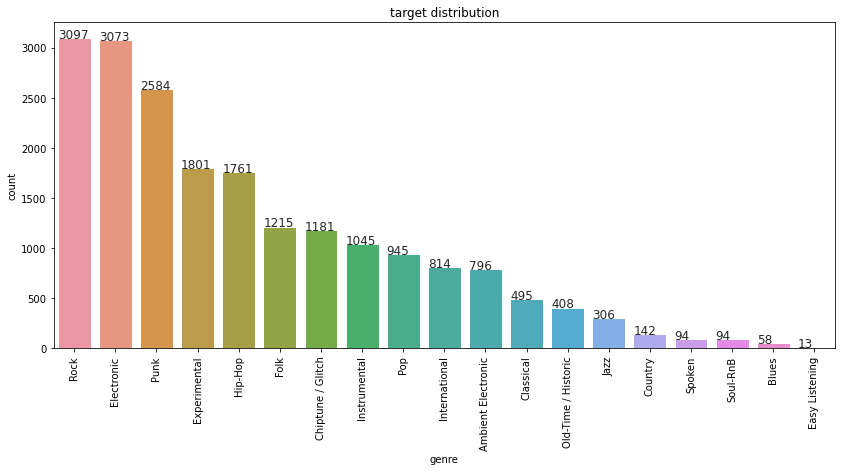

In [7]:
target_counts = df_train.genre.value_counts()
bar_plot(
            target_counts.values, 
            target_counts.index, 
            ylabel="count", 
            xlabel="genre", 
            title="target distribution"
        )

In [8]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=None, res_type="kaiser_fast")
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = conf.time_steps * conf.hop_length    
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[start_sample : start_sample+length_samples]        
    else: # pad blank
        padding = length_samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y, sr

In [9]:
def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(y=audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [10]:
def to_imagenet(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = (V - norm_min) / (norm_max - norm_min)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return np.stack([V]*3, axis=-1)

In [11]:
def create_melspec(filename):
    data, sample_rate = librosa.load(filename, sr=None)
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    melspec = librosa.power_to_db(S, ref=np.max)
    return melspec

In [12]:
# def save_melspec_img(smel, img_path):
#     plt.interactive(False)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)
#     ax.set_frame_on(False)
#     librosa.display.specshow(smel)    
#     plt.savefig(img_path, dpi=400, bbox_inches='tight',pad_inches=0)
#     plt.close()    
#     fig.clf()
#     plt.close(fig)
#     plt.close('all')
#     del fig,ax

In [13]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def save_melspec_image(y, img_path):
    if not os.path.exists(img_path):                                
        # use log-melspectrogram
        mels = librosa.feature.melspectrogram(
            y=y, 
            sr=conf.sampling_rate, 
            n_mels=conf.n_mels,
            n_fft=conf.n_fft, 
            hop_length=conf.hop_length
        )
        mels = np.log(mels + 1e-9) # add small number to avoid log(0)
        # min-max scale to fit inside 8-bit range
        img = scale_minmax(mels, 0, 255).astype(np.uint8)
        img = np.flip(img, axis=0) # put low frequencies at the bottom in image
        img = 255-img # invert. make black==more energy
        img = np.stack([img]*3, axis=-1)
        # save as PNG
        skimage.io.imsave(img_path, img)
        return img

In [14]:
def extract_mfcc_features(audio_path):
    mfccs_processed = None
    if os.path.exists(audio_path):
        audio, sample_rate = read_audio(conf, audio_path, True)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T,axis=0)     
    return mfccs_processed

In [16]:
df_train = df_train.head(10)
df_train["mfcc"] = df_train.filename.apply(lambda filename: extract_mfcc_features(DATA_PATH + "train/" + filename))
df_train

,song_id,filename,filepath,genre_id,genre,file_exists,mfcc
0,10150,010150.ogg,train/010150.ogg,7,Instrumental,True,"[-256.21112, 125.60442, -0.42895874, 85.35346,..."
1,7358,007358.ogg,train/007358.ogg,2,Punk,True,"[-37.284946, 120.587944, -26.513258, 50.83251,..."
2,20573,020573.ogg,train/020573.ogg,5,Folk,True,"[-364.31793, 154.59741, -48.284782, 15.837085,..."
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic,True,"[-346.21207, 202.10587, -74.181465, -60.517387..."
4,16662,016662.ogg,train/016662.ogg,1,Rock,True,"[-48.237347, 141.68365, -49.396336, 69.53004, ..."
5,1019,001019.ogg,train/001019.ogg,1,Rock,True,"[-425.60098, 153.21176, -2.032017, 41.243004, ..."
6,11198,011198.ogg,train/011198.ogg,9,International,True,"[-197.7892, 175.92896, -20.256489, 52.65617, -..."
7,23169,023169.ogg,train/023169.ogg,6,Chiptune / Glitch,True,"[-222.39153, 188.17297, 0.06469536, 29.87595, ..."
8,839,000839.ogg,train/000839.ogg,9,International,True,"[-175.49854, 151.82642, -10.360539, 41.347256,..."
9,22444,022444.ogg,train/022444.ogg,3,Experimental,True,"[-269.2519, 161.96178, -33.65622, 19.209917, -..."


In [18]:
df_train.loc[0, "mfcc"].shape

(40,)

In [73]:
import os

def create_processing_dirs():
    if not os.path.isdir("/kaggle/train"):
        os.mkdir("/kaggle/train")
    if not os.path.isdir("/kaggle/test"):
        os.mkdir("/kaggle/test")            

In [80]:
def audio_to_melspec(file_path, folder_path):
    filename_no_ext = file_path.split("/")[-1].split(".")[0]
    file_path = DATA_PATH + file_path    
    if os.path.exists(file_path):
        y, sr = read_audio(conf, file_path, True)
        if not os.path.isdir(folder_path + "mel_spec_224/"):
            os.mkdir(folder_path + "mel_spec_224/")
        smel_img_path = folder_path + "mel_spec_224/" + filename_no_ext + ".jpg"        
        smel = save_melspec_image(y, smel_img_path)                 
    return file_path

In [81]:
from tqdm.notebook import tqdm
from joblib import delayed, Parallel

create_processing_dirs()
delayed_funcs_train = [delayed(audio_to_melspec)(row["filepath"], "/kaggle/train/") 
                       for i, row in df_train[df_train.file_exists].iterrows()]
results_train = Parallel(n_jobs=-1, verbose=5)(delayed_funcs_train)    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    2.7s
/tmp/ipykernel_638/33778567.py:2: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_638/33778567.py:18: UserWarning: ./data/processed_train/mel_spec/024156.jpg is a low contrast image
[Parallel(n_jobs=-1)]: Done 14947 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 16642 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 16840 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 17074 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 17344 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 17650 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 17992 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 18370 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1

In [83]:
delayed_funcs_test = [delayed(audio_to_melspec)(row["filepath"], "/kaggle/test/") 
                      for i, row in df_test[df_test.file_exists].iterrows()]
results_test = Parallel(n_jobs=-1, verbose=5)(delayed_funcs_test)    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.3min
/tmp/ipykernel_638/33778567.py:2: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_638/33

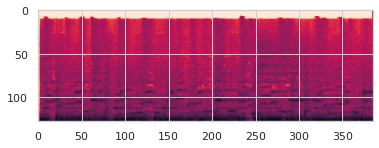

In [93]:
# zip the processed_train and processed_test folders
!zip -rq spectograms.zip /kaggle/processed_train/mel_spec
!zip -rq spectograms.zip /kaggle/processed_test/mel_spec